<a href="https://colab.research.google.com/github/Nazneen-akram/healthcare-insurance-fraud/blob/main/initial_EDA_Fraud_Claims_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

#Functions to join Dataset
##**'Beneficiary'**, **'Inpatient'**, **'Outpatient'** and **'Fraud'** into **'merged.csv'**

1.   **join_inpatient_outpatient():** : Function to merge inpatient, outpatient dataframe
2.   **join_inpatient_outpatient_beneficiary()**: Function to merge merged df, beneficiary dataframe
3. **join_inpatient_outpatient_beneficiary_fraud()**: Function to merge merged df, fraud dataframe
4. **join_csv()**: Function to join csv files. Joining by key BeneID, Provider.
5. **generate_merged_data()**: mainfunction to join csv files. calls read_data and join_csv functions



In [8]:
def read_data():
    """
    function to read csv files
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        fraud=pd.read_csv("/content/Train-1542865627584.csv")
        beneficiary=pd.read_csv("/content/Train_Beneficiarydata-1542865627584.csv")
        inpatient=pd.read_csv("/content/Train_Inpatientdata-1542865627584.csv")
        outpatient=pd.read_csv("/content/Train_Outpatientdata-1542865627584.csv")
        return fraud, beneficiary, inpatient, outpatient
    except FileExistsError as error:
        raise error

In [9]:
def join_inpatient_outpatient(inpatient, outpatient):
    """
    function to merge inpatient, outpatient dataframe
    parameters: inpatient, outpatient
    return: merged dataframe
    """
    inpatient['is_Admitted'] = 1
    outpatient['is_Admitted'] = 0
    # Merge the inpatient and outpatient dataframes
    inpatient_outpatient = pd.concat([inpatient,outpatient])

    return inpatient_outpatient


def join_inpatient_outpatient_beneficiary(inpatient_outpatient, beneficiary):
    """
    function to merge merged df, beneficiary dataframe
    parameters: inpatient, outpatient merged and beneficiary
    return: merged dataframe
    """
    inpatient_outpatient_beneficiary=pd.merge(inpatient_outpatient,beneficiary,
                                left_on='BeneID',right_on='BeneID',how='inner')
    return inpatient_outpatient_beneficiary


def join_inpatient_outpatient_beneficiary_fraud(inpatient_outpatient_beneficiary, fraud):
    """
    function to merge merged df, fraud dataframe
    parameters: inpatient, outpatient merged, beneficiary and fraud
    return: merged dataframe
    """
    inpatient_outpatient_beneficiary_fraud=pd.merge(fraud,inpatient_outpatient_beneficiary,
                                                    on='Provider')
    return inpatient_outpatient_beneficiary_fraud


def join_csv(fraud, beneficiary, inpatient, outpatient):
    """
    function to join csv files. Joining by key BeneID, Provider.
    parameters: fraud, beneficiary, inpatient, outpatient dataframes
    return: merged csv
    """
    # Join the files
    merged = join_inpatient_outpatient(inpatient, outpatient)
    merged = join_inpatient_outpatient_beneficiary(merged, beneficiary)
    merged = join_inpatient_outpatient_beneficiary_fraud(merged, fraud)

    # Save the merged file as a CSV
    merged.to_csv('/content/merged.csv', index=False)


def generate_merged_data():
    """
    mainfunction to join csv files. calls read_data and join_csv functions
    parameters: None
    return: None
    """
    fraud, beneficiary, inpatient, outpatient = read_data()
    join_csv(fraud, beneficiary, inpatient, outpatient)



In [10]:
generate_merged_data()

In [11]:
def read_data():
    """
    function to read csv file
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        merged = pd.read_csv("/content/merged.csv",low_memory=False)
    except FileExistsError as error:
        raise error
    return merged

##Module to perform data preprocesssing. This will be first level preprocessing. For visualization
##and machine learning modeling seperate preprocessing will be required according to the requirements.

In [12]:
def encoding_potential_fraud(dataframe):
    # Encode 'PotentialFraud' from Yes/No to 1/0
    dataframe['PotentialFraud'] = dataframe['PotentialFraud'].map({'Yes': 1, 'No': 0})
    return dataframe


def encode_categorical_data(dataframe):
    # List of chronic condition columns to encode
    chronic_conditions = [
        'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
        'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
        'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
    ]
    # Encode chronic conditions from 2 to 0
    for condition in chronic_conditions:
        dataframe[condition] = dataframe[condition].replace(2, 0)

    # Encode 'RenalDiseaseIndicator' from 'Y' to 1
    dataframe['RenalDiseaseIndicator'] = dataframe['RenalDiseaseIndicator'].replace('Y', 1)
    return dataframe


def add_admit_column(dataframe):
    # Convert 'AdmissionDt' and 'DischargeDt' to datetime and calculate stay duration
    dataframe['AdmissionDt'] = pd.to_datetime(dataframe['AdmissionDt'], format='%Y-%m-%d')
    dataframe['DischargeDt'] = pd.to_datetime(dataframe['DischargeDt'], format='%Y-%m-%d')
    dataframe['AdmitForDays'] = ((dataframe['DischargeDt'] - dataframe['AdmissionDt']).dt.days) + 1
    return dataframe


def add_age_column(dataframe):
    # Convert 'DOB' and 'DOD' to datetime and calculate age
    dataframe['DOB'] = pd.to_datetime(dataframe['DOB'], format='%Y-%m-%d')
    dataframe['DOD'] = pd.to_datetime(dataframe['DOD'], format='%Y-%m-%d', errors='ignore')
    # Calculate age at time of death or at the end of data collection period
    dataframe['Age'] = round(((dataframe['DOD'] - dataframe['DOB']).dt.days) / 365)
    dataframe['Age'].fillna(round(((pd.to_datetime('2009-12-01', format='%Y-%m-%d') - dataframe['DOB']).dt.days) / 365), inplace=True)
    return dataframe


def adding_dead_column(dataframe):
    # Determine if a person is dead (1) or alive (0) based on 'DOD'
    dataframe.loc[dataframe['DOD'].isna(), 'Dead_or_Alive'] = 0
    dataframe.loc[dataframe['DOD'].notna(), 'Dead_or_Alive'] = 1
    return dataframe


def add_claim_duration_column(dataframe):
    # Calculate the claim duration in days
    dataframe['ClaimStartDt'] = pd.to_datetime(dataframe['ClaimStartDt'], format="%Y-%m-%d")
    dataframe['ClaimEndDt'] = pd.to_datetime(dataframe['ClaimEndDt'], format="%Y-%m-%d")
    dataframe['Claim_Duration'] = (dataframe['ClaimEndDt'] - dataframe['ClaimStartDt']).dt.days
    return dataframe


In [13]:

def create_columns_visualization(dataframe, state_mapping):
    """
    Adds columns to indicate patient status, age, state, admission duration, and insurance claim reimbursement buckets.

    Parameters:
    - dataframe: The input DataFrame.
    - state_mapping: DataFrame containing state mappings.

    Returns:
    - DataFrame with new columns added.
    """
    # Filter for inpatient records
    inpatient_final_df = dataframe.loc[dataframe['is_Admitted'] == 1]

    # Calculate the claim duration in days
    inpatient_final_df['ClaimDuration'] = (inpatient_final_df['ClaimEndDt'] - inpatient_final_df['ClaimStartDt']).dt.days

    # Calculate patient's age using a fixed reference date (for simplicity)
    inpatient_final_df['Age'] = inpatient_final_df['DOB'].apply(lambda x: datetime.strptime("2013-03-03", '%Y-%m-%d').year - x.year)

    # Merge inpatient data with state mapping based on 'State' column to add state names
    inpatient_final_df = inpatient_final_df.merge(state_mapping, on='State', how='left')

    # Categorize admission duration into buckets
    inpatient_final_df['Days_Admitted_Bucket'] = inpatient_final_df['AdmitForDays'].apply(lambda x: "0-20 Days" if x <= 20 else "More than 20 Days")

    # Categorize insurance claim amounts into buckets based on the amount reimbursed
    inpatient_final_df['InscClaimAmtReimbursed_Bucket'] = inpatient_final_df['InscClaimAmtReimbursed'].apply(lambda x: "0 - 20000" if x <= 20000 else ("20000 - 40000" if x <= 40000 else ("40000 - 60000" if x <= 60000 else "Greater than 60000")))

    return inpatient_final_df


def save_csv(dataframe):
    """
    Saves the given dataframe to a CSV file for later use.
    Parameters:
    - dataframe: The dataframe to be saved.

    Returns:
    - None
    """
    # Save the dataframe to a CSV file without the index
    dataframe.to_csv('/content/preprocessed.csv', index=False)


def save_test_data(x_test, y_test):
    """
    Saves the test features and labels to separate CSV files.
    Parameters:
    - x_test: The test features dataframe.
    - y_test: The test labels dataframe.

    Returns:
    - None
    """
    # Save the test features and labels to CSV files without the index
    x_test.to_csv('/content/test.csv', index=False)
    y_test.to_csv('/content/test_labels.csv', index=False)


def pre_processing():
    """
    Executes a series of preprocessing functions on the data.

    Returns:
    - A modified dataframe with additional features and encoding.
    """
    # Read the initial data
    dataframe = read_data()

    # Encode categorical variables
    dataframe = encode_categorical_data(dataframe)

    # Add a column for admission days
    dataframe = add_admit_column(dataframe)

    # Add a column for patient age
    dataframe = add_age_column(dataframe)

    # Add a column indicating whether the patient is dead or alive
    dataframe = adding_dead_column(dataframe)

    # Encode the 'PotentialFraud' column to numerical
    dataframe = encoding_potential_fraud(dataframe)

    # Add claim duration feature
    dataframe = add_claim_duration_column(dataframe)

    return dataframe



In [14]:

def main_processing():
    """
    Main function to preprocess data, create visualizations, split data into training and testing sets,
    and save processed data to CSV.
    """
    # Preprocess the data and save the initial preprocessed CSV
    dataframe = pre_processing()
    save_csv(dataframe)  # Save the preprocessed data

    # Load state mapping data for further visualization
    state_mapping = pd.read_csv("/content/State_Mapping.csv")
    # Create a new dataframe for visualization purposes and save it
    viz_df = create_columns_visualization(dataframe, state_mapping)
    viz_df.to_csv('/content/visualization.csv', index=False)

    # Split the data into features and labels for model training
    features = dataframe.drop("PotentialFraud", axis=1)
    labels = dataframe['PotentialFraud']

    # Perform the train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        features, labels, random_state=1, test_size=0.10, shuffle=True)

    # Process the training data and save to CSV
    process_data(x_train, y_train, '/content/training_data.csv')

    # Process the testing data and save to CSV
    process_data(x_test, y_test, '/content/testing_data.csv', is_train=False)

def process_data(x, y=None, filepath='/content/data.csv', is_train=True):
    """
    Process data by selecting numeric types, filling NA values, and optionally concatenating labels.

    Parameters:
    - x: Features DataFrame.
    - y: Labels Series (optional).
    - filepath: Path to save processed data.
    - is_train: Boolean indicating if the data is training data.

    Returns:
    - Processed DataFrame.
    """
    # Select numeric columns and fill NA values with 0
    x_numeric = x.select_dtypes(include=['number']).fillna(0)

    # If processing training data, concatenate features with labels
    if is_train:
        dataframe = pd.concat([x_numeric, y], axis=1)
    else:
        dataframe = x_numeric

    # Save the processed data to the specified CSV file path
    dataframe.to_csv(filepath, index=False)
    return dataframe




In [15]:
# Call the main processing function to execute the data preparation
main_processing()

<ipython-input-13-fc9f44ca930f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpatient_final_df['ClaimDuration'] = (inpatient_final_df['ClaimEndDt'] - inpatient_final_df['ClaimStartDt']).dt.days
<ipython-input-13-fc9f44ca930f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpatient_final_df['Age'] = inpatient_final_df['DOB'].apply(lambda x: datetime.strptime("2013-03-03", '%Y-%m-%d').year - x.year)


##Initial EDA After Pre-processing
###Module to perform initial eda on merged dataset to get
###initial idea about the dataset for preprocessing and further computations.
###imports: numpy, pandas

In [69]:
def read_data():
    """
    function to read csv file
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        merged=pd.read_csv("/content/preprocessed.csv")
    except FileExistsError as error:
        raise error
    return merged

def get_unique_values(dataframe):
    """
    function to get unique values of dataframe
    parameters: merged dataset
    return: None
    """
    unique_vals = dataframe.nunique().sort_values()
    #print("Number of unique values:\n", unique_vals)
    unique_vals_df = pd.DataFrame(unique_vals, columns=['Number of Unique Values'])
    return unique_vals_df


def get_dimention(dataframe):
    """
    function to get number of rows and columns, all columns, to show first 5 data.
    parameters: merged dataset
    return: None
    """
    print(dataframe.describe())
    print("Number of rows and columns:", dataframe.shape)
    print("\nColumn names:\n", dataframe.columns)
    print("\nFirst  rows:\n", dataframe.head())


def get_missing_data(dataframe):
    """
    function to prints the percentage of missing values in each column.
    parameters: merged dataset
    return: None
    """
    total_missing = dataframe.isnull().sum().sort_values(ascending=False)
    percent_missing = (total_missing / len(dataframe)) * 100
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    print("Percentage of missing values:\n", missing_data)


def plot_fraud_distribution(dataframe):
    """
    Function to plot the distribution of fraud and non-fraud claims.

    Parameters:
    - dataframe: DataFrame with 'PotentialFraud' column indicating fraud status.
    """
    # Calculate the counts of fraud and non-fraud claims
    fraud_counts = dataframe['PotentialFraud'].value_counts(normalize=True) * 100
    # Convert the counts to a DataFrame
    fraud_df = fraud_counts.reset_index()
    fraud_df.columns = ['Fraud Status', 'Percentage']

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Fraud Status', y='Percentage', hue='Fraud Status', data=fraud_df, palette='pastel', legend=False)

    # Adding the text labels for bar plots
    for index, row in fraud_df.iterrows():
        barplot.text(row.name, row.Percentage, round(row.Percentage,2), color='black', ha="center")

    plt.ylabel('Number of Claims (%)')
    plt.xlabel('Fraud or Not?')
    plt.title('Distribution of Fraud & Non-fraud Claims')
    plt.show()


def plot_heatmap(data, columns):
    """
    Plot a correlation heatmap for specified chronic condition columns.

    Parameters:
    - data: DataFrame, the input data containing the specified columns.
    - columns: list, columns for which the heatmap will be generated.

    Returns:
    - None
    """
    # Calculate the correlation matrix
    correlation_matrix = data[columns].corr()

    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True)
    plt.title("Correlation Heatmap: Chronic Conditions vs. PotentialFraud")
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.show()

chronic_condition_columns = [
    'ChronicCond_Alzheimer',
    'ChronicCond_Heartfailure',
    'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer',
    'ChronicCond_ObstrPulmonary',
    'ChronicCond_Depression',
    'ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart',
    'ChronicCond_Osteoporasis',
    'PotentialFraud'
]



def get_admit_analysis(dataframe):
    """
    function to get range of admitdays
    parameters: merged dataset, columns for which we want to plot
    return: None
    """
    # Lets check Min and Max values of AdmitforDays column in Train and Test.
    print('Min Admit:- ',dataframe.AdmitForDays.min())
    print('Max Admit:- ',dataframe.AdmitForDays.max())
    dataframe.AdmitForDays.isnull().sum()   #Check Null values.


def age_distribution(dataframe):
    """
    Function to display two age distributions based on 'PotentialFraud' values using seaborn's histplot.

    Parameters:
    - dataframe: Preprocessed dataset with 'Age' and 'PotentialFraud' columns.

    Returns:
    - Displays two histograms of the age distribution based on 'PotentialFraud'.
    """
    with plt.style.context('seaborn'):
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 8))

        # Plot age distribution for 'PotentialFraud' = 0
        sns.histplot(dataframe[dataframe['PotentialFraud'] == 0]['Age'], color='lightblue', bins=20, label='PotentialFraud = 0')

        # Plot age distribution for 'PotentialFraud' = 1
        fraud_data = dataframe[dataframe['PotentialFraud'] == 1]['Age']
        sns.histplot(fraud_data, color='pink', bins=20, label='PotentialFraud = 1')

        # Adding percentage text labels for 'PotentialFraud' = 1
        total_fraud = len(fraud_data)
        for index, value in fraud_data.value_counts().items():
          percentage = '{:.0f}%'.format((value / total_fraud) * 100)
          plt.text(index, value + 5, percentage, ha='center', va='top', fontsize=10)


        # Providing the labels and title to the graph
        plt.xlabel("\nBeneficiaries Age in years")
        plt.ylabel("Frequency of patients\n")
        plt.grid(linestyle="--", color='lightgrey')
        plt.minorticks_on()
        plt.title("Distribution of Beneficiaries' Age based on PotentialFraud")
        plt.legend()
        plt.show()  # Display the plot



def plot_claim_duration_fraud(dataframe):
    """
    Creates a boxen plot to visualize claim duration against potential fraud.

    Parameters:
    - dataframe: DataFrame containing 'PotentialFraud' and 'Claim_Duration' columns.
    """
    with plt.style.context('seaborn-dark'):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10,8))
        sns.boxenplot(data=dataframe, x='PotentialFraud', y='Claim_Duration', hue='PotentialFraud', palette='pastel')
        plt.xlabel("Potentially Fraud?", fontsize=12, fontweight='bold')
        plt.xticks(rotation=90, fontsize=12)
        plt.ylabel("Claim Duration (in days)", fontsize=12, fontweight='bold')
        plt.title("Claim Duration for Potentially Fraud & Non-Fraud Providers", fontsize=14, fontweight='bold')
        plt.grid(linestyle="--", color='lightgrey')
        plt.show()


def claim_duration_fraud_alive(dataframe):
    """
    Creates a boxen plot to visualize claim duration against potential fraud status,
    differentiated by whether the patient is alive or not.

    Parameters:
    - dataframe: DataFrame containing 'PotentialFraud', 'Claim_Duration', and 'Is_Alive?' columns.
    """
    with plt.style.context('seaborn-poster'):
      sns.boxenplot(data=dataframe, x='PotentialFraud', y='Claim_Duration', hue='Dead_or_Alive', palette='pastel')
      plt.xlabel("Potentially Fraud?")
      plt.xticks(rotation=90, fontsize=12)
      plt.ylabel("Claim Duration (in days)")
      plt.grid(linestyle="--", color='lightgrey')
      plt.title("Claim Duration and Patient Life Status for Potentially Fraud & Non-Fraud Providers")
      plt.show()



def claim_duration_by_race(dataframe):
    """
    Creates a boxen plot to visualize claim duration against potential fraud status,
    differentiated by the race of the claimants.

    Parameters:
    - dataframe: DataFrame containing 'PotentialFraud', 'Claim_Duration', and 'Race' columns.
    """
    with plt.style.context('seaborn-poster'):
        plt.figure(figsize=(16,8))
        sns.boxenplot(data=dataframe, x='PotentialFraud', y='Claim_Duration', hue='Race', palette='cubehelix')
        plt.xlabel("Potentially Fraud?")
        plt.xticks(rotation=90, fontsize=12)
        plt.ylabel("Claim Duration (in days)")
        plt.grid(linestyle="--", color='lightgrey')
        plt.title("Claim Duration across different Races for Potentially Fraud & Non-Fraud Providers")
        plt.legend(loc='upper center', title='Race')
        plt.show()



def attending_physician_distribution(dataframe):
    """
    Plot the distribution of AttendingPhysician.

    Parameters:
    - data: DataFrame, the input data containing the 'AttendingPhysician' column.

    Returns:
    - None
    """
    plt.figure(figsize=(16, 6))
    sns.set_style('whitegrid')
    sns.countplot(data=dataframe, x='AttendingPhysician', order=dataframe['AttendingPhysician'].value_counts()[:10].index, color='lightgreen')
    plt.xticks(size=10)
    plt.yticks(size=12)
    plt.title('Distribution of AttendingPhysician', fontsize=20)
    plt.xlabel('AttendingPhysician', size=14)
    plt.ylabel('Count', size=14)
    plt.show()



def get_eda():
    """
    function get complete eda
    parameters: None
    return: None
    """
    merged = read_data()
    saved = merged
    get_unique_values(merged)
    get_dimention(merged)
    get_missing_data(merged)
    get_admit_analysis(merged)
    plot_fraud_distribution(merged)
    plot_heatmap(merged,chronic_condition_columns)
    age_distribution(merged)
    plot_claim_duration_fraud(merged)
    claim_duration_fraud_alive(merged)
    claim_duration_by_race(merged)
    attending_physician_distribution(merged)

<ipython-input-69-8aa831780265>:9: DtypeWarning: Columns (14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  merged=pd.read_csv("/content/preprocessed.csv")


       PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
count   558211.000000           558211.000000      557312.000000   
mean         0.381211              997.012133          78.421085   
std          0.485685             3821.534891         274.016812   
min          0.000000                0.000000           0.000000   
25%          0.000000               40.000000           0.000000   
50%          0.000000               80.000000           0.000000   
75%          1.000000              300.000000           0.000000   
max          1.000000           125000.000000        1068.000000   

       ClmProcedureCode_1  ClmProcedureCode_2  ClmProcedureCode_3  \
count        23310.000000         5490.000000          969.000000   
mean          5896.154612         4106.358106         4221.123839   
std           3050.489933         2031.640878         2281.849885   
min             11.000000           42.000000           42.000000   
25%           3848.000000         2724.000

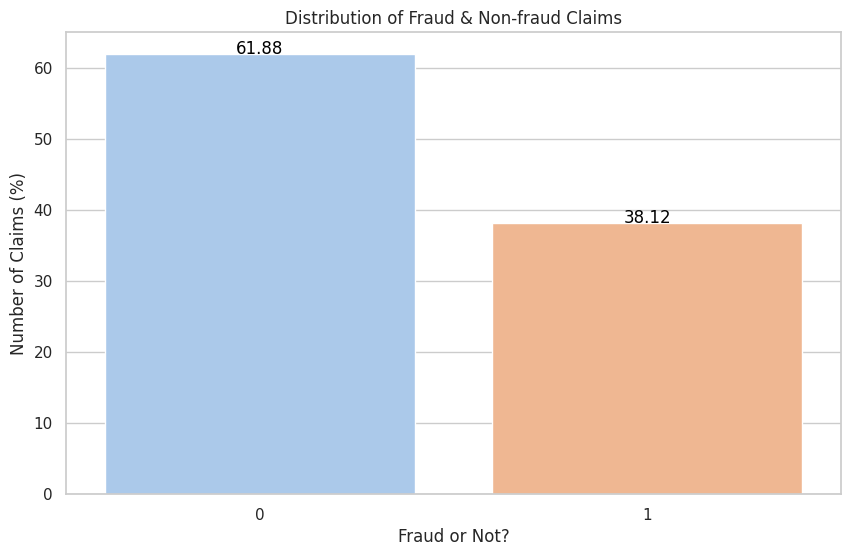

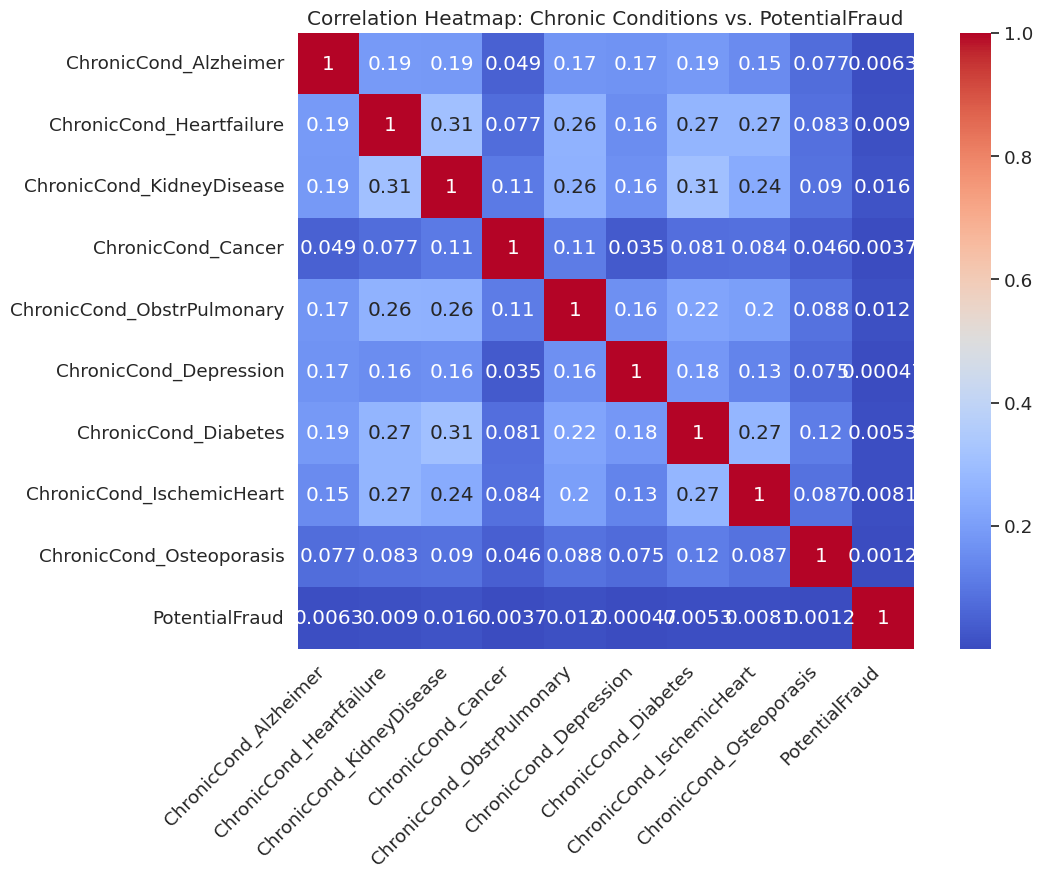

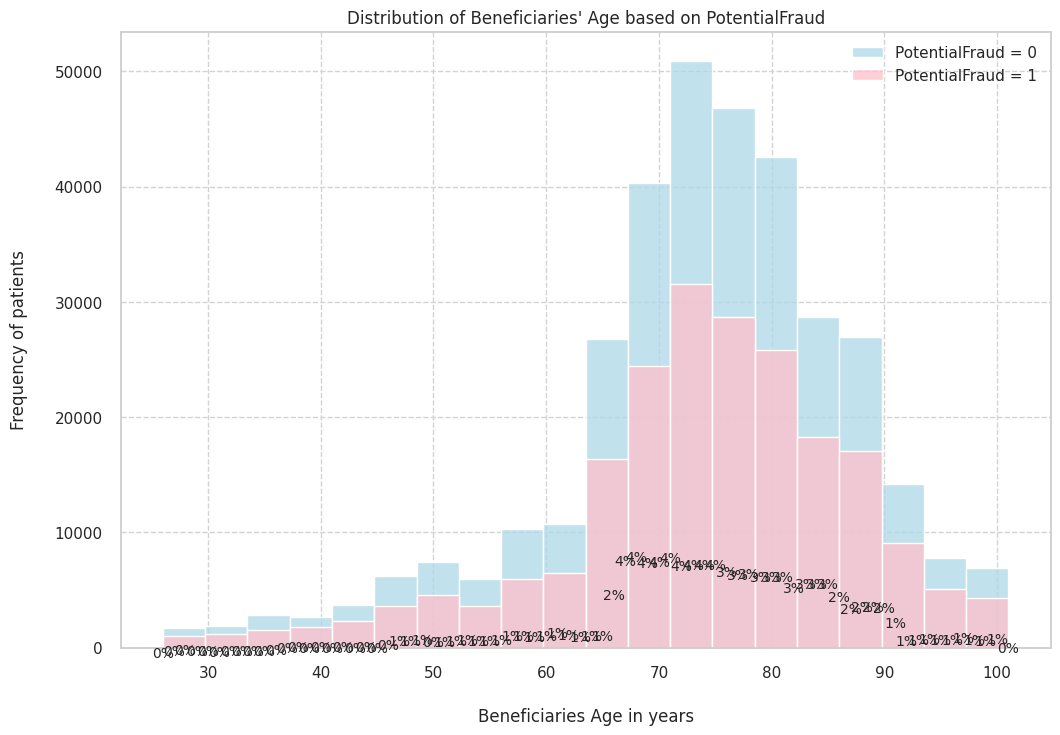

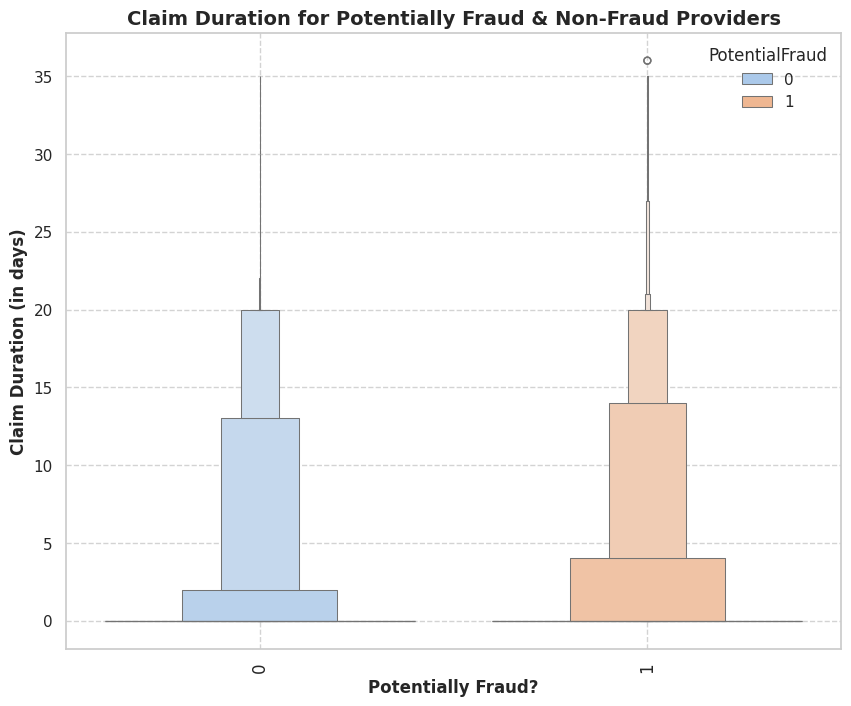

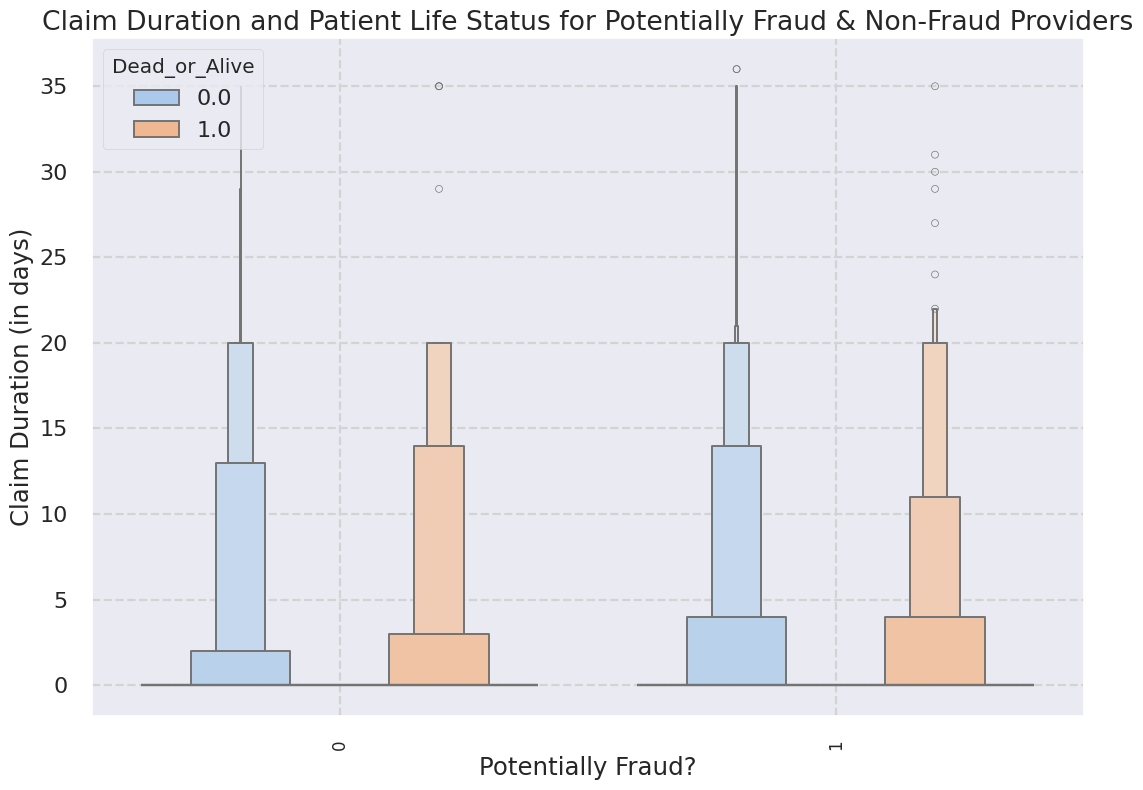

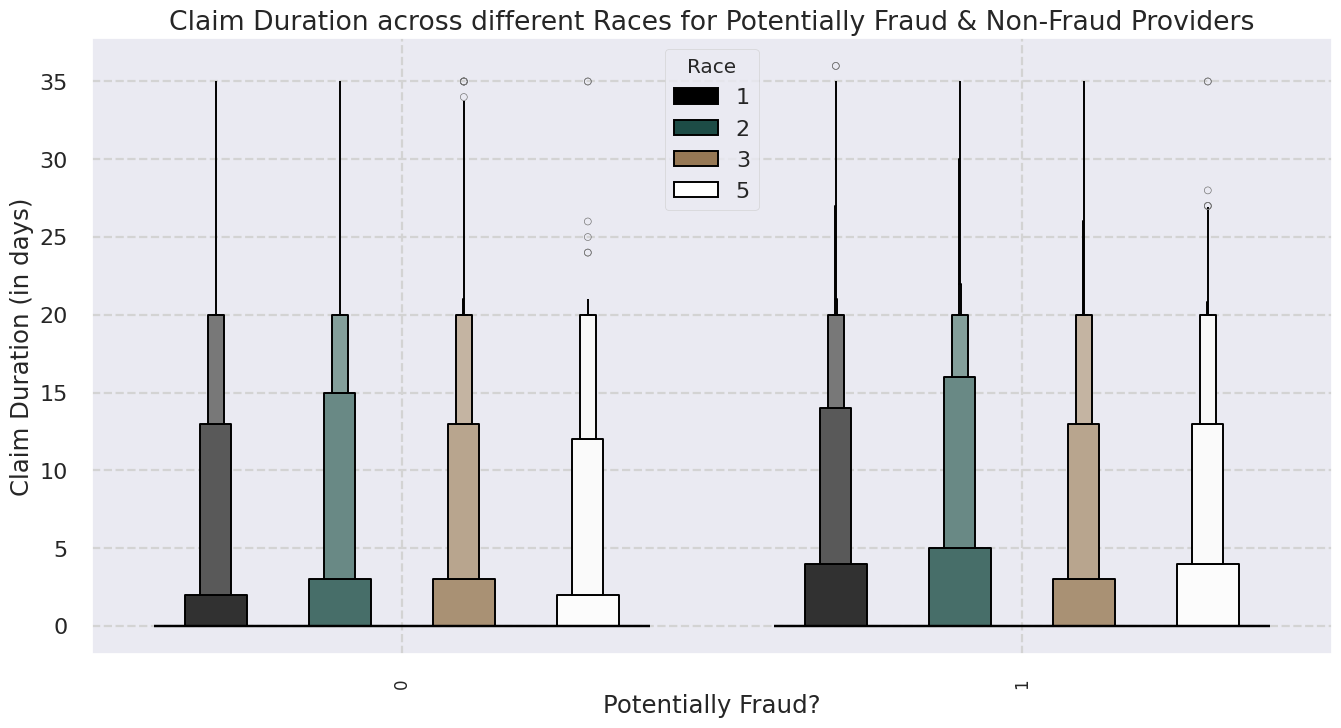

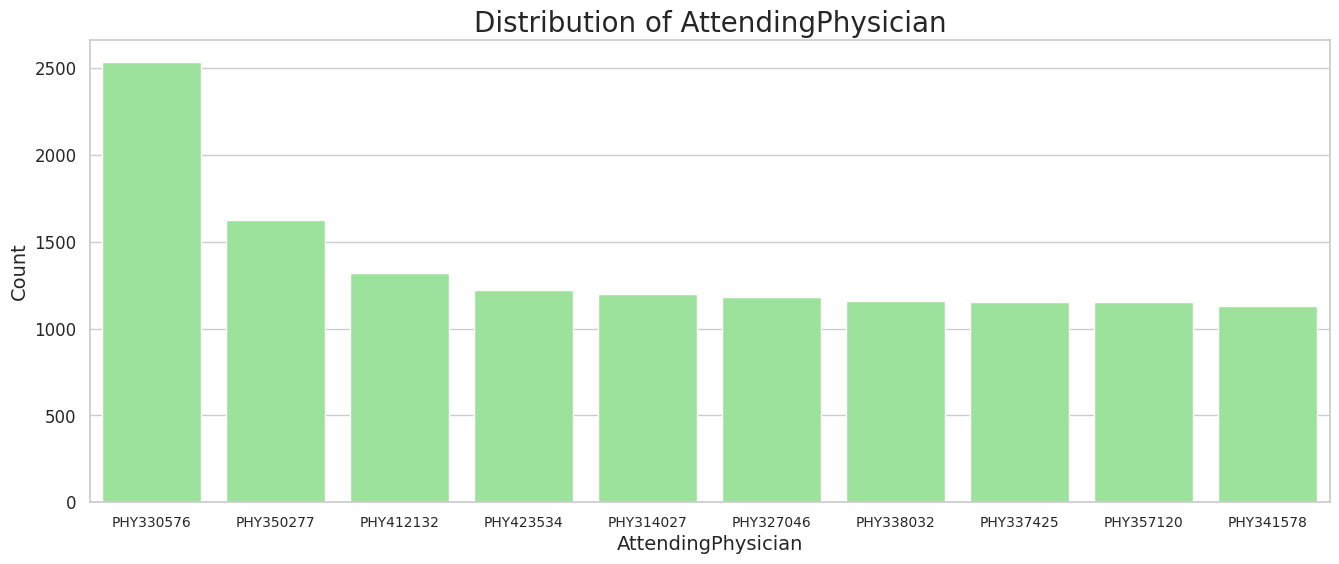

In [70]:
get_eda()